In [1]:
# load python packages - pep 8 specifies core packages first... third party next
import os
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import geopandas as gpd
import rasterio as rio
from rasterio.plot import plotting_extent

import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es

# prettier plotting
#import seaborn as sns
# sns.set(font_scale=1.5)
# sns.set_style("white")


et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))


## Open Raster Data  Using Context Manager

In [2]:
# Because i may use the path to the data several times, i'm constructing the path in 2 steps!
data_path = os.path.join("data", "colorado-flood",
                         "spatial", "boulder-leehill-rd")
dtm_path = os.path.join(data_path, "pre-flood", "lidar", "pre_DTM.tif")

#dtm_path = 'data/colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DTM.tif'

with rio.open(dtm_path) as dtm_src:
    # reading the data into numpy as an array
    # set masked = true to import a masked array (no data values = masked)
    lidar_dtm_pre = dtm_src.read(1, masked=True)
    # printing some metadata - specifically the bounds or spatial extent of the data
    print(dtm_src.bounds)
    # Grab the spatial extent for plotting
    spatial_extent = plotting_extent(dtm_src)
    dtm_pre_meta = dtm_src.meta

type(lidar_dtm_pre)
lidar_dtm_pre.shape
dtm_pre_meta

BoundingBox(left=472000.0, bottom=4434000.0, right=476000.0, top=4436000.0)


{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028234663852886e+38,
 'width': 4000,
 'height': 2000,
 'count': 1,
 'crs': CRS.from_epsg(32613),
 'transform': Affine(1.0, 0.0, 472000.0,
        0.0, -1.0, 4436000.0)}

## Plot The Data 

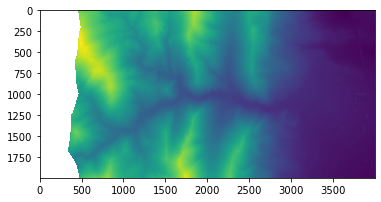

In [3]:
f, ax = plt.subplots()
ax.imshow(lidar_dtm_pre)
plt.show()

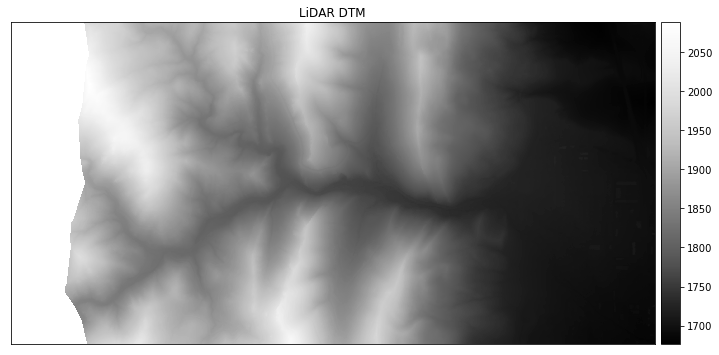

In [4]:
# Use earthpy to plot the data this will work until you want to add a custom legend

ep.plot_bands(lidar_dtm_pre,
              title="LiDAR DTM",
              cmap="Greys_r",
              scale=False)
plt.show()

In [5]:
# View the shape or the pixel dimensions of the raster
# Note that .shape is a numpy array ATTRIBUTE
lidar_dtm_pre.shape

(2000, 4000)

## Create a Histogram of Raster Data
frequency  -- of elevations values

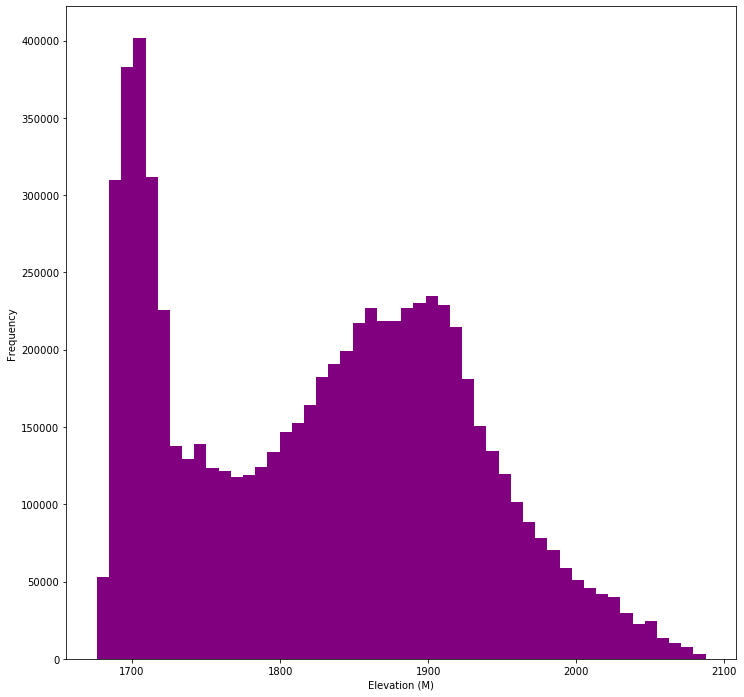

In [6]:
# Remember that you don't want to use plt.show() in your homework!!
ep.hist(lidar_dtm_pre, bins=50,
        xlabel="Elevation (M)",
        ylabel="Frequency")
plt.show()

## Open Digital Surface Model from the Pre Flood Data

In [7]:
# Open up pre-flood DSM
dsm_pre_path = os.path.join(data_path, "pre-flood", "lidar", "pre_DSM.tif")

with rio.open(dsm_pre_path) as dsm_src:
    lidar_dsm_pre = dsm_src.read(1, masked=True)
    # This is the spatial plotting extent that you will need to plot with a
    # Vector overlay
    spatial_extent_dsm = plotting_extent(dsm_src)


# Check if the shape and CRS are the same for each raster before subtracting

print(lidar_dsm_pre.shape == lidar_dtm_pre.shape)
print(dsm_src.crs == dtm_src.crs)

True
True


## Subtract the Rasters

In [8]:
# subtract the dtm from the DSM to create a CHM
# IMPORTANT: be sure to review the lidar lessons!!
lidar_chm_pre = lidar_dsm_pre - lidar_dtm_pre
# view min and max value of the calculated CHM -- numpy array attributes
lidar_chm_pre.max(), lidar_chm_pre.min()

(26.930054, 0.0)

In [9]:
# the output calculated image is a masked array
lidar_chm_pre

masked_array(
  data=[[--, --, --, ..., 0.0, 0.1700439453125, 0.9600830078125],
        [--, --, --, ..., 0.0, 0.090087890625, 1.6400146484375],
        [--, --, --, ..., 0.0, 0.0, 0.0799560546875],
        ...,
        [--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 0.0, 0.0, 0.0]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=-3.402823e+38,
  dtype=float32)

/opt/conda/lib/python3.7/site-packages/numpy/ma/core.py:1015: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


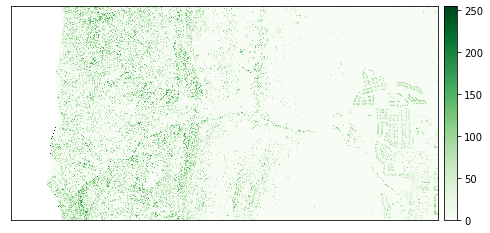

In [10]:
# The commented line below can be used if you want to interact with your raster (mouse over to view values)
# %matplotlib notebook
# TODO: This is now throwing a runtime warning... Your instructor is looking into why!

# plot the data - chm data
ep.plot_bands(lidar_chm_pre,
              figsize=(8, 4),
              cmap="Greens")
plt.show()

## Classify The Canopy Height Model

Classify in this instance refers to reassigning values in an existing raster to another value.

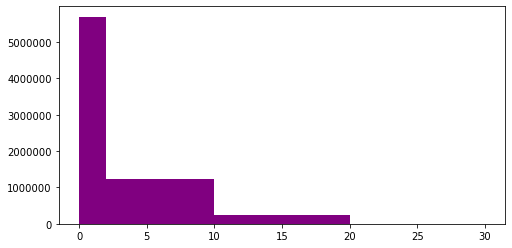

In [11]:
# plot a histogram of the data but specify the bins you'd like to see
ep.hist(lidar_chm_pre,
        bins=[0, 2, 10, 20, 30],
        figsize=(8, 4))
plt.show()  # remember to not use plt.show() in your homework as it messes up the autograder

In [12]:
lidar_chm_pre.min(), lidar_chm_pre.max()
type(lidar_chm_pre)

numpy.ma.core.MaskedArray

In [13]:
# classify the data using np.digitize()

# define the bins to use in classification
class_bins = [-np.inf, 0, 2, 7, 12, np.inf]
# classify your raster using numpy digitize
# Remember that digitize is simple reassigning existing values to a new value as specified
# in your class_bins list above!
lidar_chm_pre_class = np.digitize(lidar_chm_pre,
                                  class_bins)

In [14]:
# View unique values in the data
# Notice that now the values span from 1-5.
# Also note that the value 1 is likely no data as it's < 0 in the class bins above
np.unique(lidar_chm_pre_class)

array([1, 2, 3, 4, 5])

In [15]:
# Have a look at the data
lidar_chm_pre_class

array([[1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       ...,
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2]])

## Just something that might be helpful to know about

Below i use the `np.ma.masked_where()` function as an example of how to mask values if you need to. You shouldn't need to this week however.  

In [16]:
# you can turn your data into a masked array if you want
lidar_chm_class_ma = np.ma.masked_where(lidar_chm_pre_class == 1,
                                        lidar_chm_pre_class,
                                        copy=True)
# View min and max values after you've removed the value == 1 using masked_where above
lidar_chm_class_ma.min(), lidar_chm_class_ma.max()

(2, 5)

In [17]:
# now you have a masked array again which will plot nicely
type(lidar_chm_class_ma)

numpy.ma.core.MaskedArray

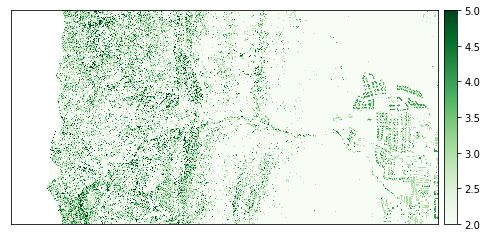

In [18]:
# plot the data!
%matplotlib inline
ep.plot_bands(lidar_chm_class_ma,
              scale=False,
              figsize=(8, 4),
              cmap="Greens")
plt.show()

## Add a Custom Legend to Your Plot with EarthPy

Note that the lessons online need to be updated!! I will do this tonight or tomorrow but you can use this code as an example of how legends work with earthpy. You can also look at the earthpy docs!!

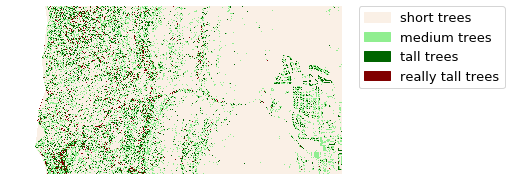

In [19]:
# This is how you can create your own custom colormap!
# This is optional but good to know how to do
colors = ['linen', 'lightgreen', 'darkgreen', 'maroon']
height_class_labels = ["short trees", "medium trees",
                       "tall trees", "really tall trees"]

# Create a colormap from a list of colors
cmap = ListedColormap(colors)

f, ax = plt.subplots()
im = ax.imshow(lidar_chm_class_ma,
               cmap=cmap)
ep.draw_legend(im, titles=height_class_labels)
# This line below turns off the ticks and black borders on your image
ax.set_axis_off()
plt.show()

## Cropping a raster using crop_image in earthpy 

The example above ran you through several raster operations. the one thing it skipped was cropping the data prior to processing it. You can crop when you import the data initially with rasterio as seen below. For your homework, you should do this when you import each raster dataset!

In [20]:
# Open the crop extent that need to crop the data!
clip_extent_path = os.path.join(data_path, "clip-extent.shp")
crop_extent = gpd.read_file(clip_extent_path)

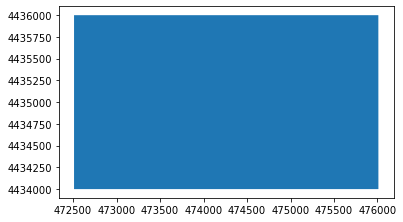

In [21]:
# View the cropped data layer
crop_extent.plot()
plt.show()

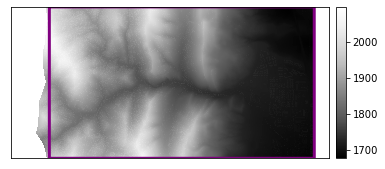

In [22]:
# overlay the two datasets
# Note that the crop extent will remove some of the uneven edge on the left (West) side of the image
f, ax = plt.subplots()
ep.plot_bands(lidar_dsm_pre,
              ax=ax,
              extent=spatial_extent_dsm,
              scale=False)
crop_extent.boundary.plot(ax=ax, edgecolor="purple",
                          color=None, linewidth=3)
plt.show()

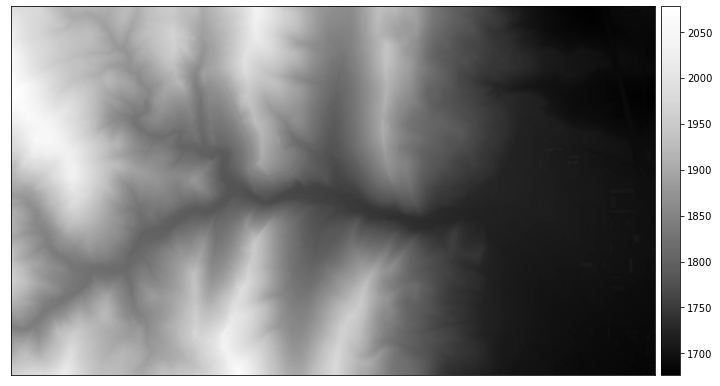

In [23]:
with rio.open(dtm_path) as pre_dtm:
    pre_dtm_crop, _ = es.crop_image(pre_dtm, crop_extent)

# Plot the cropped data
ep.plot_bands(pre_dtm_crop, scale=False)
plt.show()